## Definitions

In [1]:
import os
import sys
import shutil
import random

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)
import pandas_ta as ta
import quantstats as qs
qs.extend_pandas()

import numpy as np
import math

from datetime import datetime, timedelta
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

params = {'figure.facecolor': 'w'}
plt.rcParams.update(params)

from IPython.display import display

''' Import custom Library '''
lib_path = '/workspace/202205_idx-trading/lib'
sys.path.insert(0, lib_path)
# Read Imports
from utils import read_config
from strat_utils import LQ45BaseStrategy
from data_utils import gen_combined_df, extend_price_df, handle_nan, RandomPriceData
from backtest import Backtest, HistoricalScenarioBacktest, RandomizedBacktest
sys.path.remove(lib_path)

### Parameter and Directories Definition

In [2]:
# Parameters
date_start = '2009-01-01'
date_breakpoint = '2010-01-01'
strat_class = "Momentum"
std = 1

In [3]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
lq45_dir = '/workspace/202205_idx-trading/_data/20220525_lq45/'
lq45_index_file = data_dir + '20220525_lq45_index.csv'
lq45_list = '20220525_lq45-list.txt'

## Data Preparation

### Data Loading
Note: Only In sample data is loaded

In [4]:
# Prepare Stock Tickers
with open(data_dir + lq45_list, "r") as f:
    lq45_tickers = f.read().split('\n')

## Prepare active tickers for international codes
active_tickers = [f + '.JK' for f in lq45_tickers]
active_tickers.append('LQ45')

In [5]:
# Prepare Time Series Data
nan_handle_method = 'bfill'

df_dict = {}
for ticker in tqdm(active_tickers):
    if ticker == 'LQ45':
        df_dict[ticker] = pd.read_csv(lq45_index_file)
    else:
        df_dict[ticker] = pd.read_csv(lq45_dir + ticker + '.csv')
    
    ## Take Only Date and Adjusted Close
    df_dict[ticker] = df_dict[ticker][['Date', 'Adj Close']]
    df_dict['Date'] = pd.to_datetime(df_dict[ticker]['Date'])
    df_dict[ticker].set_index(pd.DatetimeIndex(df_dict[ticker]['Date']), inplace=True)
    
    df_dict[ticker].drop('Date', axis=1, inplace=True)
    
    ## Convert Adj Close to price
    df_dict[ticker]['price'] = df_dict[ticker]['Adj Close']
    df_dict[ticker].drop('Adj Close', axis=1, inplace=True)

100%|█████████████████████████████████████████████████████| 46/46 [00:00<00:00, 70.69it/s]


In [6]:
# Generate In Sample Dataset
nan_cnt_threshold = 252*2

in_df = {}
out_df = {}
rmv_tickers = []
for ticker in tqdm(active_tickers):
    ## Take In Sample and Out Sample Data
    in_df[ticker] = df_dict[ticker][(df_dict[ticker].index >= date_start) & 
                                                (df_dict[ticker].index < date_breakpoint)]
    
    ## Check if there are too many NaN values
    if in_df[ticker]['price'].isna().sum() > nan_cnt_threshold:
        rmv_tickers.append(ticker)
        continue
    
    ## Handle NaN Values
    in_df[ticker] = handle_nan(in_df[ticker], method=nan_handle_method)
    
    ## Extend price to other values
    in_df[ticker] = extend_price_df(in_df[ticker])

# Remove tickers that only have small amounts of data
active_tickers = [t for t in active_tickers if t not in rmv_tickers]

100%|████████████████████████████████████████████████████| 46/46 [00:00<00:00, 373.53it/s]


## Strategy Design
Done by the Robert Carver method: https://www.youtube.com/watch?app=desktop&v=-aT55uRJI8Q

In [93]:
class BinaryEWMACStrategy(LQ45BaseStrategy):
    '''
    Exponential Moving Average Crossover Strategy.
    
    - Signal is generated in a binary manner (buy/sell) 
    - Stop loss and profit target is also defined
    '''
    def __init__(self, config=None, config_filepath=None, mode="paper_trade"):
        super().__init__(config=config, config_filepath=config_filepath, mode=mode)
        
        if config is not None:
            config_dict = config
        
        elif config_filepath is not None:
            config_dict = read_config(config_filepath)
            
        else:
            assert config is not None, "Either config or config_filepath must be available"
            
        # Strategy Parameters
        strat_params = config_dict['strat_params']
        
        self.long_only = strat_params['long_only']
        
        self.raw_tickers = strat_params['tickers']
        self.tickers = self.raw_tickers
        
        self.lookback_fast = strat_params['lookback_fast']
        self.lookback_slow = strat_params['lookback_slow']
        self.vol_lookback = strat_params['vol_lookback']
        
        self.profit_target_frac = strat_params["profit_target_frac"] 
        if (self.profit_target_frac == ""): self.profit_target_frac = 999
        self.stop_loss_frac = strat_params["stop_loss_frac"]
        if (self.stop_loss_frac == ""): self.stop_loss_frac = 999
    
    def prepare_indicators(self, df_dict, vol_adj=False, lookback_postfix=True):
        strat_df = gen_combined_df(df_dict, self.raw_tickers, ['price'], add_pfix=True)
        
        # Rename Tickers to contain lookback_postfix
        if lookback_postfix:
            lookback_indicator = str(self.lookback_fast) + "/" + str(self.lookback_slow)
            self.tickers = [t + "-" + lookback_indicator for t in self.raw_tickers]
            
            for r_t, t in zip(self.raw_tickers, self.tickers):
                price_r_t = "price_" + r_t
                price_t = "price_" + t
                strat_df.rename(columns={price_r_t: price_t}, inplace=True)
        else:
            self.tickers = self.raw_tickers
        
        for t in self.tickers:
            price_t = "price_" + t
            ewmac_t = "ewmac_" + t
            vol_adj_ewmac_t = "vol-adj-ewmac_" + t
            
            fast_ewma = strat_df[price_t].ewm(span=self.lookback_fast).mean()
            slow_ewma = strat_df[price_t].ewm(span=self.lookback_slow).mean()
            strat_df[ewmac_t] = fast_ewma - slow_ewma
            
            if vol_adj:
                stdev_ret = (strat_df[price_t] - strat_df[price_t].shift(1)).ewm(span=self.vol_lookback).mean()
                strat_df[vol_adj_ewmac_t] = strat_df[ewmac_t] / stdev_ret
            
        return strat_df
    
    def gen_signals(self, strat_df, remove_overshoot_signal=False):
        
        # Signal Rules
        uptrend_signal = lambda ewmac: ewmac > 0
        downtrend_signal = lambda ewmac: ewmac <= 0
        
        stop_loss_signal = lambda returns: returns <= -self.stop_loss_frac 
        take_profit_signal = lambda returns: returns >= self.profit_target_frac
        
        # Prepare Signal
        last_signal = {}
        last_price = {}
        
        signal_tickers = ["signal_" + t for t in self.tickers]
        for signal_t in signal_tickers:
            strat_df[signal_t] = ''
            last_signal[signal_t] = ''
            last_price[signal_t] = None
        
        # Generate Signals
        if not self.long_only:
            for t in self.tickers:
                signal_t = "signal_" + t
                ewmac_t = "ewmac_" + t

                for i in range(0, len(strat_df)):
                    if i == 0:
                        strat_df[signal_t][i] = ''

                    elif last_signal[signal_t] == '':
                        if uptrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = 'long_entry'
                        elif downtrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = 'short_entry'
                        else:
                            strat_df[signal_t][i] = ''

                    elif last_signal[signal_t] == 'long_entry':
                        unrealized_returns = (strat_df[price_t][i] - last_price[signal_t])/last_price[signal_t]
                        
                        if stop_loss_signal(unrealized_returns):
                            # Stop Loss
                            strat_df[signal_t][i] = 'long_close'
                        elif take_profit_signal(unrealized_returns):
                            # Take Profit
                            strat_df[signal_t][i] = 'long_close'
                        
                        elif uptrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = ''
                        elif downtrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = 'long_close'
                        else:
                            strat_df[signal_t][i] = ''

                    elif last_signal[signal_t] == 'short_entry':
                        unrealized_returns = -(strat_df[price_t][i] - last_price[signal_t])/last_price[signal_t]
                        
                        if stop_loss_signal(unrealized_returns):
                            # Stop Loss
                            strat_df[signal_t][i] = 'long_close'
                        elif take_profit_signal(unrealized_returns):
                            # Take Profit
                            strat_df[signal_t][i] = 'long_close'
                        
                        elif uptrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = 'short_close'
                        elif downtrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = ''
                        else:
                            strat_df[signal_t][i] = ''

                    elif last_signal[signal_t] == 'long_close' or last_signal[signal_t] == 'short_close':
                        if uptrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = 'long_entry'
                        elif downtrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = 'short_entry'
                        else:
                            strat_df[signal_t][i] = ''
                            
                    if strat_df[signal_t][i] != "":
                        last_signal[signal_t] = strat_df[signal_t][i]
                        last_price[signal_t] = strat_df[price_t][i]
                            
        elif self.long_only:
            for t in self.tickers:
                price_t = "price_" + t
                signal_t = "signal_" + t
                ewmac_t = "ewmac_" + t

                for i in range(0, len(strat_df)):
                    if i == 0:
                        strat_df[signal_t][i] = ''
                    
                    elif last_signal[signal_t] == '':
                        if uptrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = 'long_entry'
                        elif downtrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = ''
                        else:
                            strat_df[signal_t][i] = ''

                    elif last_signal[signal_t] == 'long_entry':
                        
                        unrealized_returns = (strat_df[price_t][i] - last_price[signal_t])/last_price[signal_t]
                        
                        if stop_loss_signal(unrealized_returns):
                            # Stop Loss
                            strat_df[signal_t][i] = 'long_close'
                        elif take_profit_signal(unrealized_returns):
                            # Take Profit
                            strat_df[signal_t][i] = 'long_close'
                            
                        elif uptrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = ''
                        elif downtrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = 'long_close'
                        else:
                            strat_df[signal_t][i] = ''
                            
                    elif last_signal[signal_t] == 'long_close':
                        if uptrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = 'long_entry'
                        elif downtrend_signal(strat_df[ewmac_t][i]):
                            strat_df[signal_t][i] = ''
                        else:
                            strat_df[signal_t][i] = ''
                            
                    if strat_df[signal_t][i] != "":
                        last_signal[signal_t] = strat_df[signal_t][i]
                        last_price[signal_t] = strat_df[price_t][i]
        
        # Remove signals for tickers not within runtime
        if remove_overshoot_signal:
            for signal_t in signal_tickers:
                strat_df.loc[strat_df.index < self.run_date_start, signal_t] = ""
        
        return strat_df
    
    def run(self):
        self.df_data_dict = self.prepare_data()
        self.strat_df = self.prepare_indicators(self.df_data_dict)
        self.strat_df = self.gen_signals(self.strat_df)
        
        return self.strat_df

### Generate Random Data

In [5]:
r = RandomPriceData()
random_data_dict = {}

# Trend lengths are based on rob carver's method (gradually increase from a week up until a year)
t_lengths = [5, 10, 15, 21, 42, 64, 85, 107, 128, 150, 171, 192, 213, 235, 256]

In [6]:
# Prepare Sawtooth Data
for tl in t_lengths:
    sawtooth_data = r.random_oscillation(n_length=512, t_length=tl, amp=3, std_scale=0.1, mode='sawtooth')
    random_data_dict[str(tl)] = pd.DataFrame(sawtooth_data, columns=['price'], index=sawtooth_data.index)

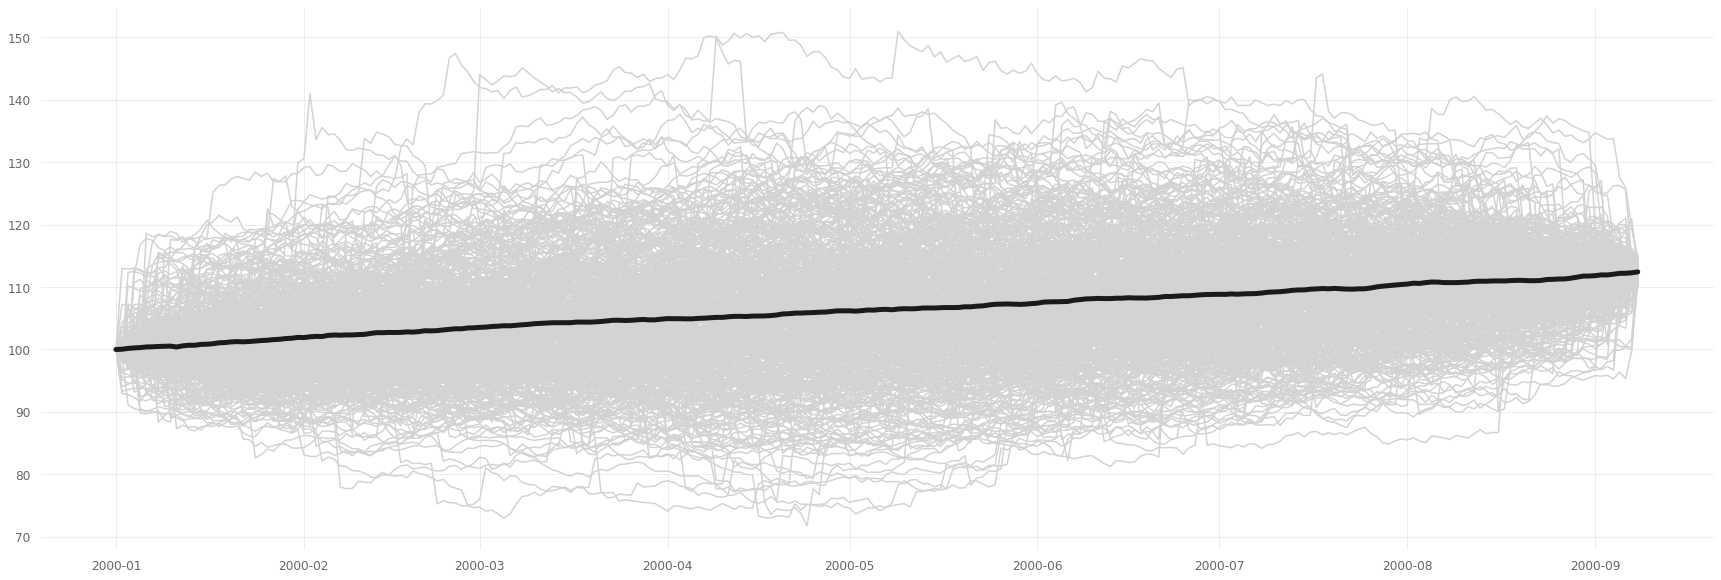

In [121]:
# Prepare Uptrend Jumpy Data
r_up = RandomPriceData()
r_up.run_simulation(r_up.random_trend, num_iter=500, movement="up", min_frac_change=0.10, max_frac_change=0.15, stochastic_process=r.jump_diffusion, n_length=252, 
                 std=0.1, drift=0.05, jump_mean=0, jump_std=0.05, poisson_rate=0.05)

r_up.plot_random_prices()

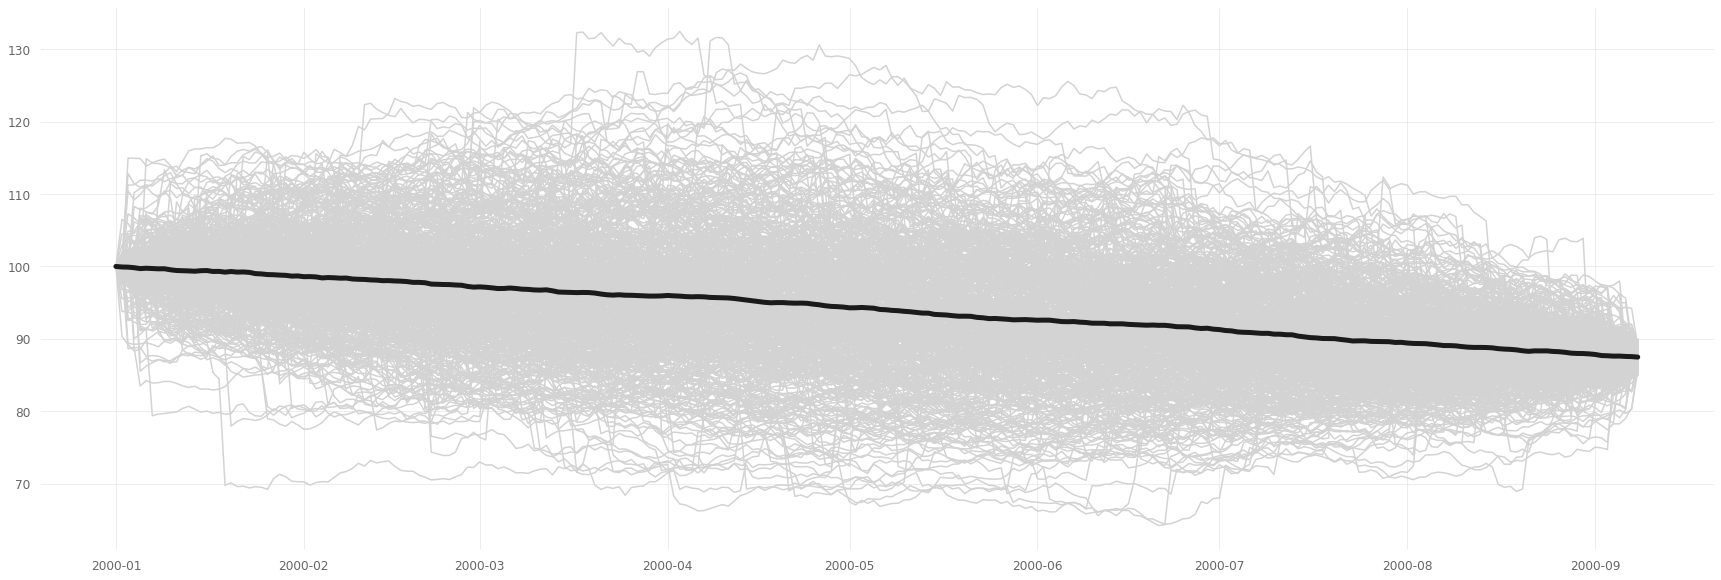

In [122]:
# Prepare Downtrend Jumpy Data
r_down = RandomPriceData()
r_down.run_simulation(r_down.random_trend, num_iter=500, movement="down", min_frac_change=0.1, max_frac_change=0.15, stochastic_process=r.jump_diffusion, n_length=252, 
                 std=0.1, drift=-0.05, jump_mean=0, jump_std=0.05, poisson_rate=0.05)

r_down.plot_random_prices()

In [ ]:
# TODO - Prepare Mean Reverting Noisy Data

### Setup Strategy

In [167]:
config = {
            "run_params":{
                "base_data_dir": "/workspace/202205_idx-trading/_data/",
                "lq45_dir": "/workspace/202205_idx-trading/_data/20220525_lq45/",
                "lq45_index_filename": "20220525_lq45_index.csv",
                "lq45_list_filename": "20220525_lq45-list.txt"
            },

            "backtest_params":{
                "run_date_start": date_breakpoint,
                "run_date_end": "full"
            },

            "strat_params":{
                "long_only": True,
                "tickers": None,
                "lookback_fast": None,
                "lookback_slow": None,
                "vol_lookback": 25,
                "profit_target_frac": "",
                "stop_loss_frac": 0.025
            }   
}

lookback_pairs = [[2, 8], [3, 12], [4, 16], [5,20], [8,32], [10,40], [12,48], [16,64], [20,80], [25, 100], [28, 112], [32, 128]]

### Run Strategy Experiment

#### Sawtooth Data

In [168]:
# Fast and Slow Lookback Variations
backtests = {}
experiment_list = []

# Generate Sharpe Ratio
# Iterate over every combination of lengths and lookback pairs
for tl in tqdm(t_lengths):
    buffer_dict = {}
    buffer_dict['tl'] = tl
    
    for lp in lookback_pairs:
        config["strat_params"]["tickers"] = [str(tl)]
        config["strat_params"]["lookback_fast"] = lp[0]
        config["strat_params"]["lookback_slow"] = lp[1]

        s = BinaryEWMACStrategy(config=config, mode="backtest")
        strat_df = s.prepare_indicators(random_data_dict)
        strat_df = s.gen_signals(strat_df)
        
        b = Backtest()
        b.init_signal(strat_df)
        b.calc_returns()
        sharpe = b.calc_sharpe()
        
        pair_str = str(lp[0]) + "_" + str(lp[1])
        backtests[pair_str + "_" + str(tl)] = b
        
        buffer_dict[pair_str] = sharpe
    
    experiment_list.append(buffer_dict)

experiments_df = pd.DataFrame(experiment_list)

100%|█████████████████████████████████████████████████████| 15/15 [01:03<00:00,  4.25s/it]


In [169]:
display(experiments_df)

,tl,2_8,3_12,4_16,5_20,8_32,10_40,12_48,16_64,20_80,25_100,28_112,32_128
0,5,-0.711890,-2.103266,-3.963614,-3.913576,-5.187357,-5.646881,-5.813133,-6.185320,-6.174591,-6.224684,-6.397821,-5.983205
1,10,1.037250,-0.206732,-0.864184,-0.447038,-2.754734,-2.912716,-3.328841,-3.737772,-3.850803,-4.051618,-3.982227,-3.958961
2,15,1.629198,0.982535,-0.328601,-0.888561,-1.433896,-1.981037,-2.485350,-3.026479,-3.451042,-3.546035,-3.548496,-3.331672
3,21,1.705385,1.695957,1.521186,0.796109,-0.451342,-0.921939,-1.366173,-2.082505,-2.911834,-2.467817,-3.052790,-3.265970
4,42,-0.438332,1.080940,0.998213,1.276911,1.216155,1.046483,1.222651,-0.249875,-0.577125,-0.481459,-0.744954,-1.026347
5,64,-3.120206,-0.555870,1.259942,1.021930,-0.109251,-0.043300,-0.044783,0.280582,0.128672,-0.276085,-0.441098,-0.388047
6,85,-4.510947,-1.326473,0.472321,0.900863,1.066702,0.880246,0.503269,0.830737,0.805775,0.585117,0.826424,0.794639
7,107,-5.275290,-3.212133,-0.849473,0.273028,0.819267,0.654772,0.836442,0.776549,1.231529,0.997779,1.143279,0.297187
8,128,-5.800495,-4.657413,-2.984716,-1.138231,0.011583,0.225954,0.417455,0.382672,0.081904,0.314813,0.241166,0.320880
9,150,-4.010550,-3.112697,-1.310096,0.220787,1.078446,1.266039,1.183827,1.323968,1.273473,1.041753,1.039718,1.164016


In [170]:
# Generate Turnovers
turnover_list = []

for tl in tqdm(t_lengths):
    buffer_dict = {}
    buffer_dict['tl'] = tl
    
    for lp in lookback_pairs:
        pair_str = str(lp[0]) + "_" + str(lp[1])
        lpt_str = pair_str + "_" + str(tl)
        
        turnover = backtests[lpt_str].calc_turnover()
        
        buffer_dict[pair_str] = turnover
        
    turnover_list.append(buffer_dict)
    
turnover_df = pd.DataFrame(turnover_list)

100%|█████████████████████████████████████████████████████| 15/15 [00:00<00:00, 51.83it/s]


In [171]:
display(turnover_df)

,tl,2_8,3_12,4_16,5_20,8_32,10_40,12_48,16_64,20_80,25_100,28_112,32_128
0,5,65,74,100,101,113,118,120,122,122,122,125,122
1,10,48,49,46,41,75,81,85,87,90,95,97,97
2,15,37,32,41,46,45,62,71,84,90,89,87,88
3,21,29,25,20,24,28,38,48,69,74,73,80,83
4,42,60,26,29,23,15,17,11,33,41,42,45,49
5,64,91,41,14,15,27,25,24,19,21,29,35,36
6,85,121,64,28,20,14,14,19,16,15,18,18,16
7,107,123,95,56,34,25,23,19,18,11,10,8,28
8,128,131,112,79,42,25,22,20,19,25,18,21,18
9,150,129,107,68,37,14,10,10,10,7,11,10,9


In [172]:
# Generate Correlations
lookback_pairs_options = [["2_8", "4_16"], ["4_16", "5_20"], ["5_20", "8_32"], ["5_20", "16_64"], ["8_32", "16_64"]]
trends_options = [["5", "10", "15", "21"], ["15", "21", "42", "64", "85"], ["42", "64", "85"], ["42", "64", "85"], ["85", "128", "256"]]

correlations_list = []

for lpo, to in tqdm(zip(lookback_pairs_options, trends_options)):
    buffer_dict = {}
    buffer_dict["lp0"] = lpo[0]
    buffer_dict["lp1"] = lpo[1]
    
    for trend in to:
        lpt_0 = lpo[0] + "_" + trend
        lpt_1 = lpo[1] + "_" + trend
        
        corr = backtests[lpt_0].strat_df['return'].corr(backtests[lpt_1].strat_df['return'])
        
        buffer_dict[trend] = corr
    
    correlations_list.append(buffer_dict)

correlations_df = pd.DataFrame(correlations_list)

5it [00:00, 758.38it/s]


In [173]:
display(correlations_df)

,lp0,lp1,5,10,15,21,42,64,85,128,256
0,2_8,4_16,0.651771,0.73619,0.715462,0.835109,NaN,NaN,NaN,NaN,NaN
1,4_16,5_20,NaN,NaN,0.934509,0.913888,0.906652,0.920132,0.929768,NaN,NaN
2,5_20,8_32,NaN,NaN,NaN,NaN,0.824400,0.795345,0.912249,NaN,NaN
3,5_20,16_64,NaN,NaN,NaN,NaN,0.584411,0.630393,0.655902,NaN,NaN
4,8_32,16_64,NaN,NaN,NaN,NaN,NaN,NaN,0.700274,0.899563,0.948791


#### Uptrend Data

In [163]:
# Generate Sharpe Ratio
# Iterate over every combination of lengths and lookback pairs

config["strat_params"]["tickers"] = ["placeholder"] # because prices are evaluated individually, the ticker isn't important for this context

metrics_dict_list = []
up_runs_dict = {}

for lp in tqdm(lookback_pairs):
    config["strat_params"]["lookback_fast"] = lp[0]
    config["strat_params"]["lookback_slow"] = lp[1]
    pair_str = str(lp[0]) + "_" + str(lp[1])
    
    buffer_dict_list = []
    metrics_dict = {}
    for ii, rs in enumerate(r_up.random_series):
        s = BinaryEWMACStrategy(config=config, mode="backtest")
        
        # Note: Dictionary is required because of a quirk in the strategy class design - definitely can be better
        strat_df = s.prepare_indicators({"placeholder": pd.DataFrame(rs, columns=["price"])}, lookback_postfix=False) 
        strat_df = s.gen_signals(strat_df)
        
        b = Backtest()
        b.init_signal(strat_df)
        b.calc_returns()
        
        buffer_dict = {
                            "rs_index": ii,
                            "turnover": b.calc_turnover(),
                            "cum_return": b.calc_cum_returns(last=True),
                            "sharpe": b.calc_sharpe(),
                            "max_dd": b.calc_dd(mode="max"),
                            "longest_dd": b.calc_dd(mode="longest")
                        }
        buffer_dict_list.append(buffer_dict)
        
    buffer_df = pd.DataFrame(buffer_dict_list)
    
    up_runs_dict[pair_str] = buffer_df
    metrics_dict = {
                        "lp": pair_str,
                        "turnover": buffer_df['turnover'].mean(),
                        "cum_return": buffer_df['cum_return'].mean(),
                        "sharpe": buffer_df['sharpe'].mean(),
                        "max_dd": buffer_df['max_dd'].mean(),
                        "longest_dd": buffer_df['longest_dd'].mean() 
                    }
    metrics_dict_list.append(metrics_dict)
    
up_metrics_df = pd.DataFrame(metrics_dict_list)

100%|█████████████████████████████████████████████████████| 12/12 [18:36<00:00, 93.04s/it]


In [164]:
display(up_metrics_df)

,lp,turnover,cum_return,sharpe,max_dd,longest_dd
0,2_8,17.844,0.028429,0.224387,-0.126944,118.020
1,3_12,12.244,0.030036,0.232175,-0.125928,117.910
2,4_16,9.540,0.033114,0.257436,-0.125390,116.722
3,5_20,7.862,0.035237,0.278068,-0.124139,114.716
4,8_32,5.648,0.035190,0.278604,-0.125299,117.670
5,10_40,4.940,0.032435,0.262777,-0.126163,117.022
6,12_48,4.508,0.031553,0.262888,-0.125153,116.594
7,16_64,3.992,0.030123,0.259072,-0.127109,116.118
8,20_80,3.712,0.026526,0.232073,-0.129197,122.850
9,25_100,3.464,0.025534,0.231193,-0.131728,116.586


In [147]:
from math import ceil

# Helper Function to Plot
def plot_series_group(series, series_ids=None, num_col=4):
    fig = plt.figure(figsize=(20,10))
    
    for ii, s in enumerate(series):
        ax = plt.subplot(ceil(len(series)/num_col), num_col, ii+1)
        
        if series_ids is not None:
            ax.set_title(series_ids[ii])
        s.plot(ax=ax)

    plt.tight_layout()
    plt.show()

In [152]:
# Top 20, Mid 20, Bottom 20 of cum_return

pair_str = "5_20"

pair_runs_df = up_runs_dict[pair_str].sort_values("cum_return")

top_runs_index = pair_runs_df["rs_index"].head(20).values

runs_len = len(pair_runs_df["rs_index"])
mid_runs_index = pair_runs_df.iloc[int(runs_len/2)-10:int(runs_len/2)+10]["rs_index"].values

bottom_runs_index = pair_runs_df["rs_index"].tail(20).values

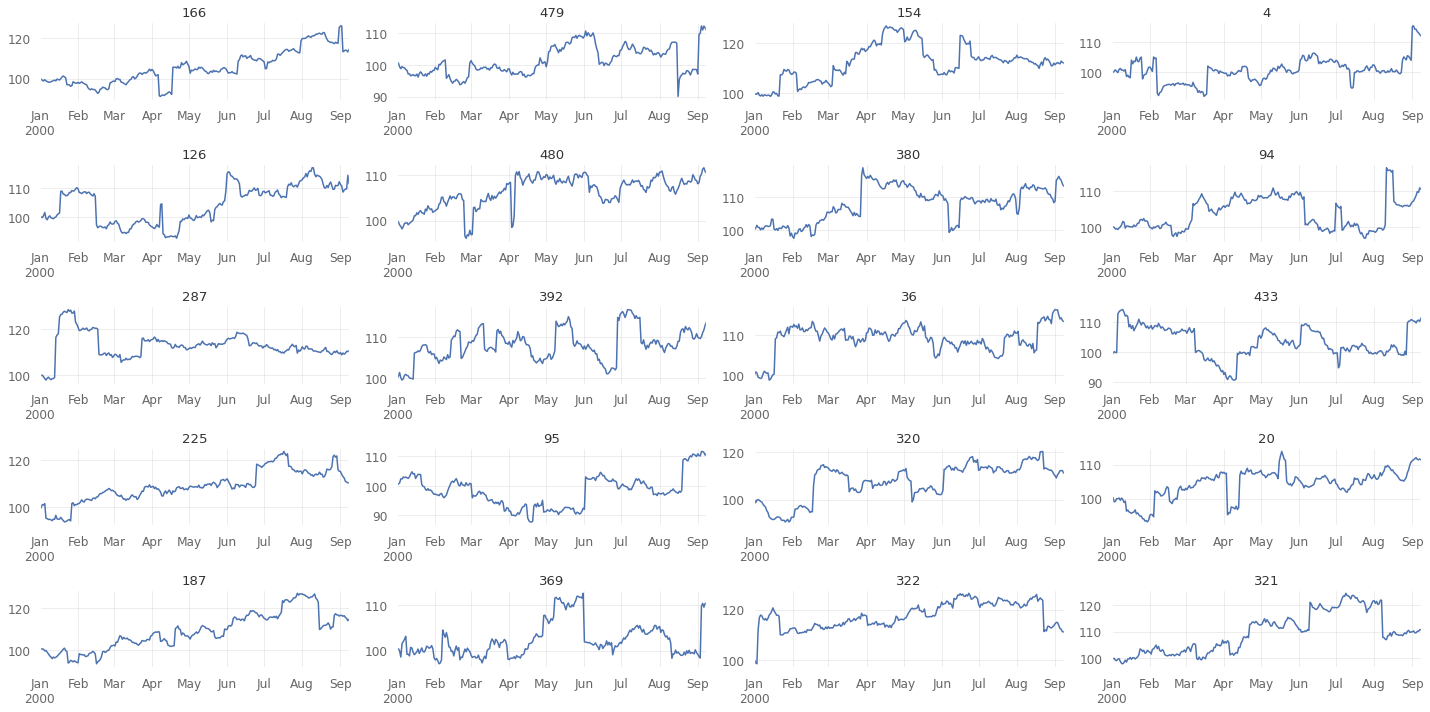

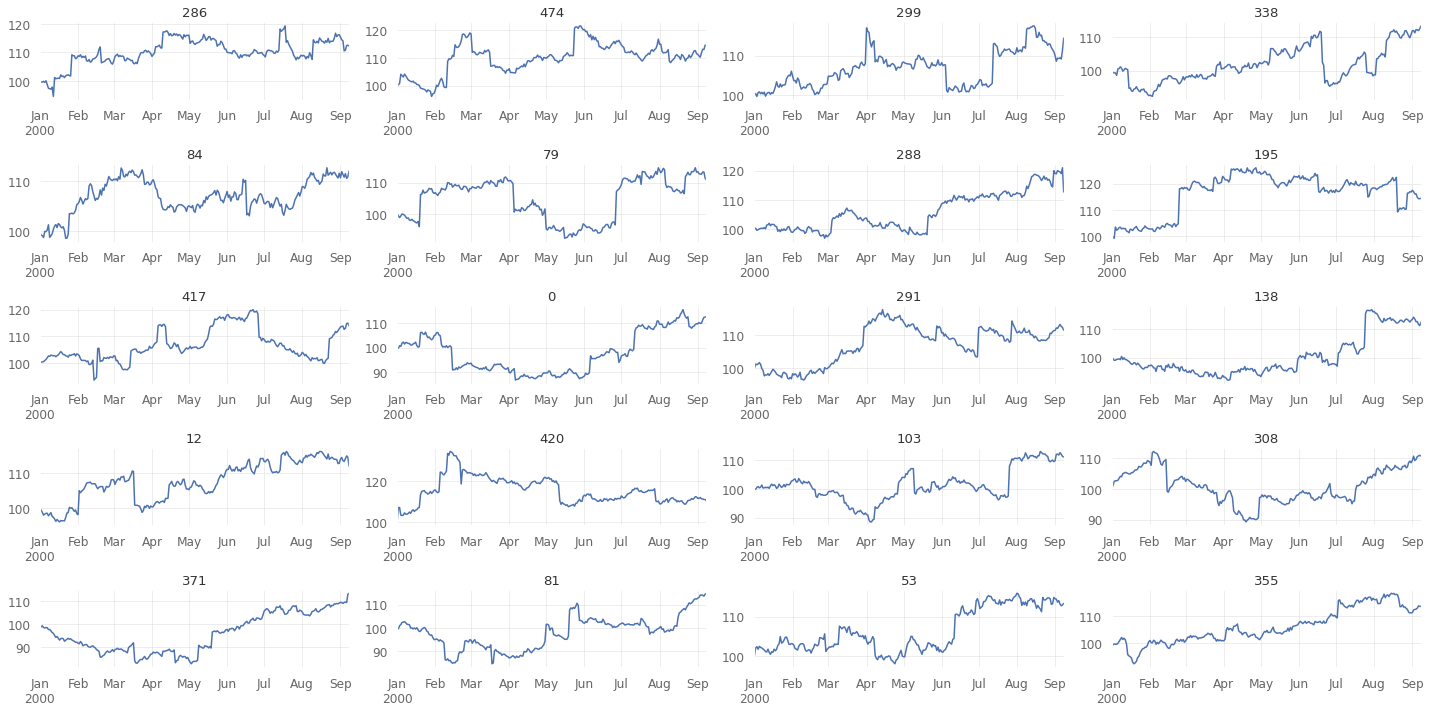

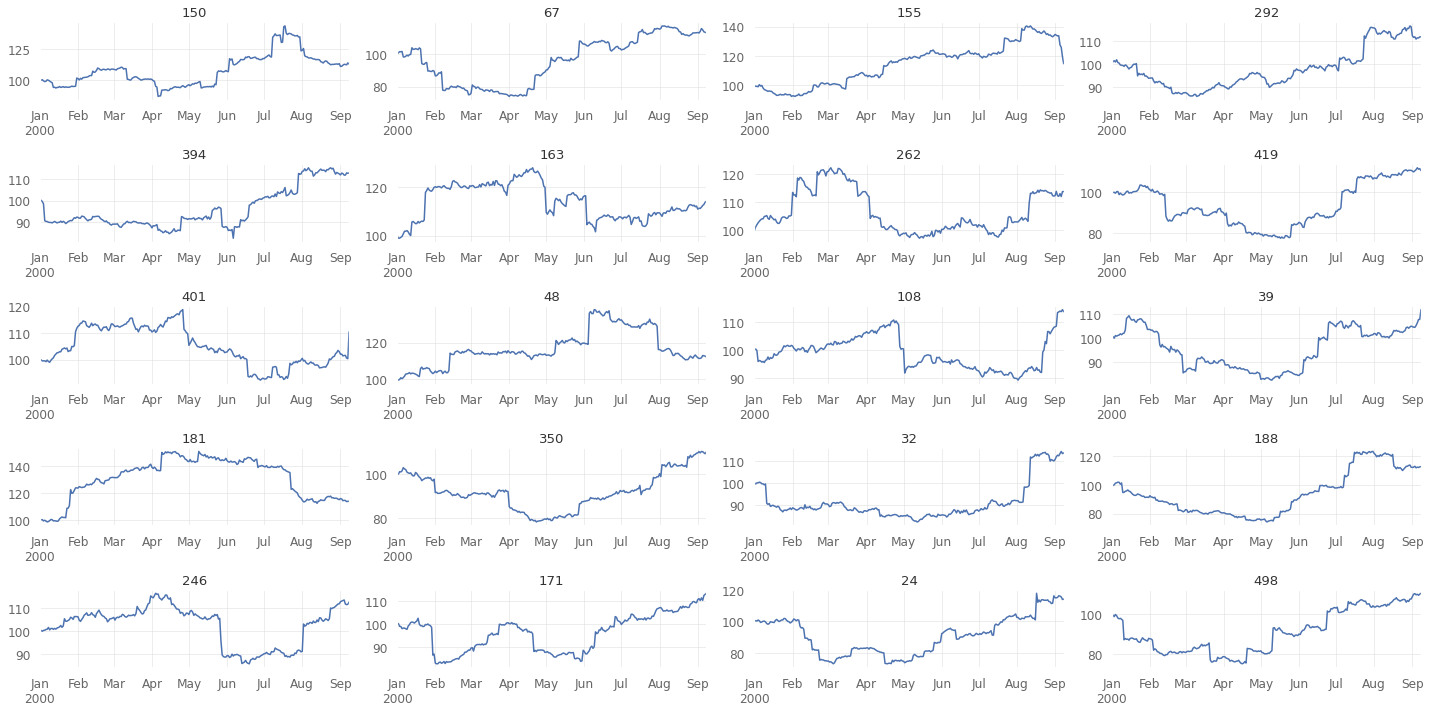

In [153]:
# Plot Each Series Groups

## Top 20
top_runs_series = [r_up.random_series[index] for index in top_runs_index]
plot_series_group(top_runs_series, series_ids=top_runs_index)

## Mid 20
mid_runs_series = [r_up.random_series[index] for index in mid_runs_index]
plot_series_group(mid_runs_series, series_ids=mid_runs_index)

## Bottom 20
bottom_runs_series = [r_up.random_series[index] for index in bottom_runs_index]
plot_series_group(bottom_runs_series, series_ids=bottom_runs_index)

#### Downtrend Data

In [165]:
# Generate Sharpe Ratio
# Iterate over every combination of lengths and lookback pairs

config["strat_params"]["tickers"] = ["placeholder"] # because prices are evaluated individually, the ticker isn't important for this context

metrics_dict_list = []
down_runs_dict = {}

for lp in tqdm(lookback_pairs):
    config["strat_params"]["lookback_fast"] = lp[0]
    config["strat_params"]["lookback_slow"] = lp[1]
    pair_str = str(lp[0]) + "_" + str(lp[1])
    
    buffer_dict_list = []
    metrics_dict = {}
    for ii, rs in enumerate(r_down.random_series):
        s = BinaryEWMACStrategy(config=config, mode="backtest")
        
        # Note: Dictionary is required because of a quirk in the strategy class design - definitely can be better
        strat_df = s.prepare_indicators({"placeholder": pd.DataFrame(rs, columns=["price"])}, lookback_postfix=False) 
        strat_df = s.gen_signals(strat_df)
        
        b = Backtest()
        b.init_signal(strat_df)
        b.calc_returns()
        
        buffer_dict = {
                            "rs_index": ii,
                            "turnover": b.calc_turnover(),
                            "cum_return": b.calc_cum_returns(last=True),
                            "sharpe": b.calc_sharpe(),
                            "max_dd": b.calc_dd(mode="max"),
                            "longest_dd": b.calc_dd(mode="longest")
                        }
        buffer_dict_list.append(buffer_dict)
        
    buffer_df = pd.DataFrame(buffer_dict_list)
    
    down_runs_dict[pair_str] = buffer_df
    metrics_dict = {
                        "lp": pair_str,
                        "turnover": buffer_df['turnover'].mean(),
                        "cum_return": buffer_df['cum_return'].mean(),
                        "sharpe": buffer_df['sharpe'].mean(),
                        "max_dd": buffer_df['max_dd'].mean(),
                        "longest_dd": buffer_df['longest_dd'].mean() 
                    }
    metrics_dict_list.append(metrics_dict)
    
down_metrics_df = pd.DataFrame(metrics_dict_list)

 75%|████████████████████████████████████████▌             | 9/12 [13:46<04:35, 91.70s/it]/usr/local/lib/python3.8/site-packages/quantstats/stats.py:293: RuntimeWarning: invalid value encountered in double_scalars
  res = returns.mean() / divisor
/usr/local/lib/python3.8/site-packages/quantstats/stats.py:293: RuntimeWarning: invalid value encountered in double_scalars
  res = returns.mean() / divisor
 83%|████████████████████████████████████████████▏        | 10/12 [15:17<03:03, 91.64s/it]/usr/local/lib/python3.8/site-packages/quantstats/stats.py:293: RuntimeWarning: invalid value encountered in double_scalars
  res = returns.mean() / divisor
/usr/local/lib/python3.8/site-packages/quantstats/stats.py:293: RuntimeWarning: invalid value encountered in double_scalars
  res = returns.mean() / divisor
/usr/local/lib/python3.8/site-packages/quantstats/stats.py:293: RuntimeWarning: invalid value encountered in double_scalars
  res = returns.mean() / divisor
 92%|██████████████████████████████

In [166]:
display(down_metrics_df)

,lp,turnover,cum_return,sharpe,max_dd,longest_dd
0,2_8,17.646,-0.091873,-0.761978,-0.159365,185.858
1,3_12,12.264,-0.088422,-0.745417,-0.155072,181.334
2,4_16,9.430,-0.080398,-0.685150,-0.148767,174.054
3,5_20,7.756,-0.076727,-0.671105,-0.144090,176.780
4,8_32,5.574,-0.077893,-0.718995,-0.140313,177.776
5,10_40,5.002,-0.077218,-0.728715,-0.137015,177.790
6,12_48,4.622,-0.077128,-0.735612,-0.135197,177.894
7,16_64,4.194,-0.077632,-0.779592,-0.132751,180.028
8,20_80,4.056,-0.080279,-0.820698,-0.132441,181.864
9,25_100,3.842,-0.082098,-0.860071,-0.131857,185.266


In [156]:
# Top 20, Mid 20, Bottom 20 of cum_return

pair_str = "5_20"

pair_runs_df = down_runs_dict[pair_str].sort_values("cum_return")

top_runs_index = pair_runs_df["rs_index"].head(20).values

runs_len = len(pair_runs_df["rs_index"])
mid_runs_index = pair_runs_df.iloc[int(runs_len/2)-10:int(runs_len/2)+10]["rs_index"].values

bottom_runs_index = pair_runs_df["rs_index"].tail(20).values

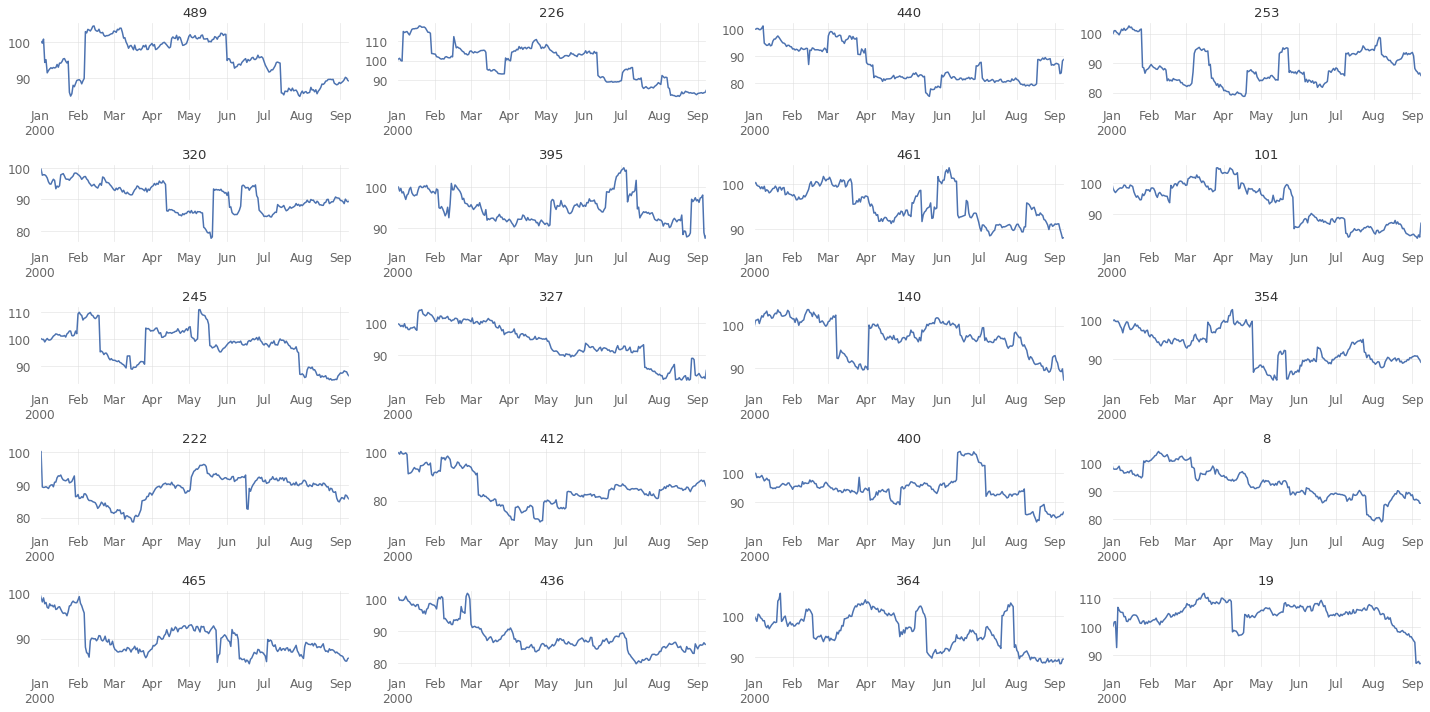

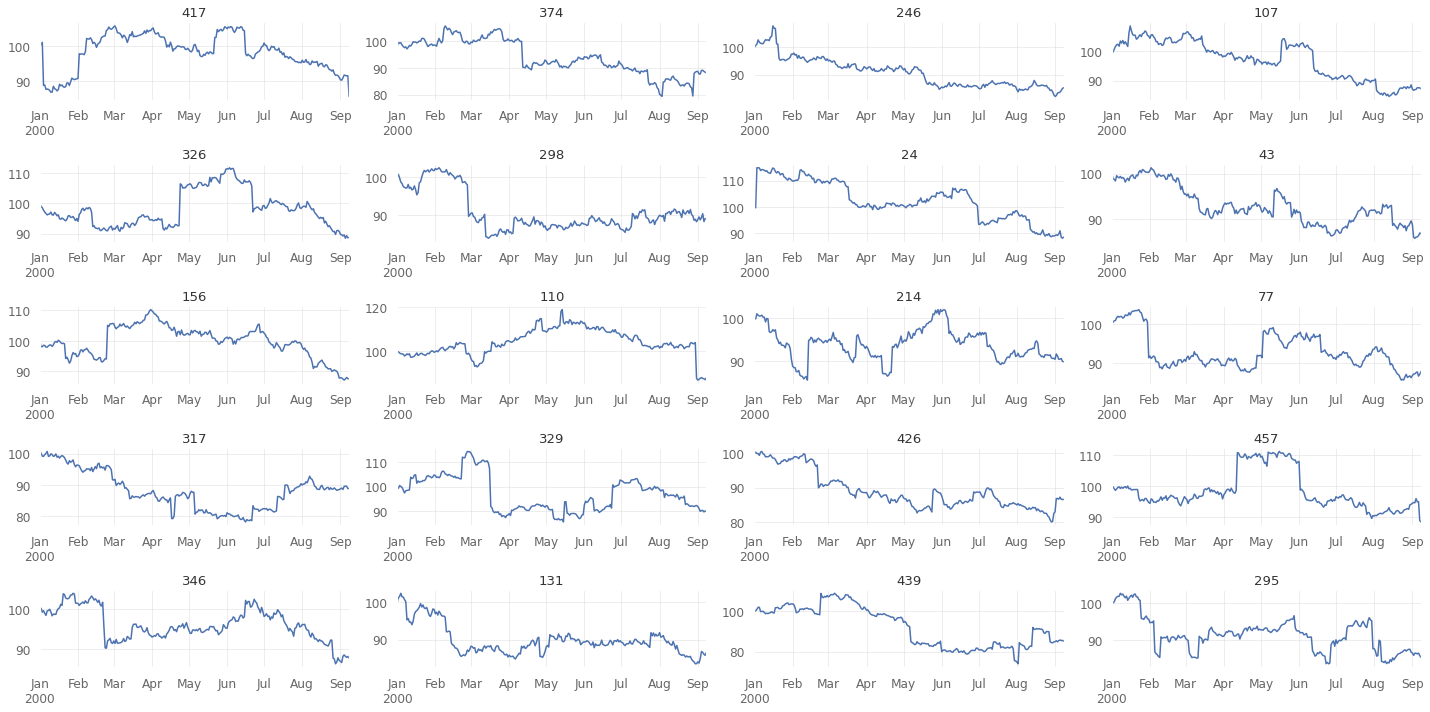

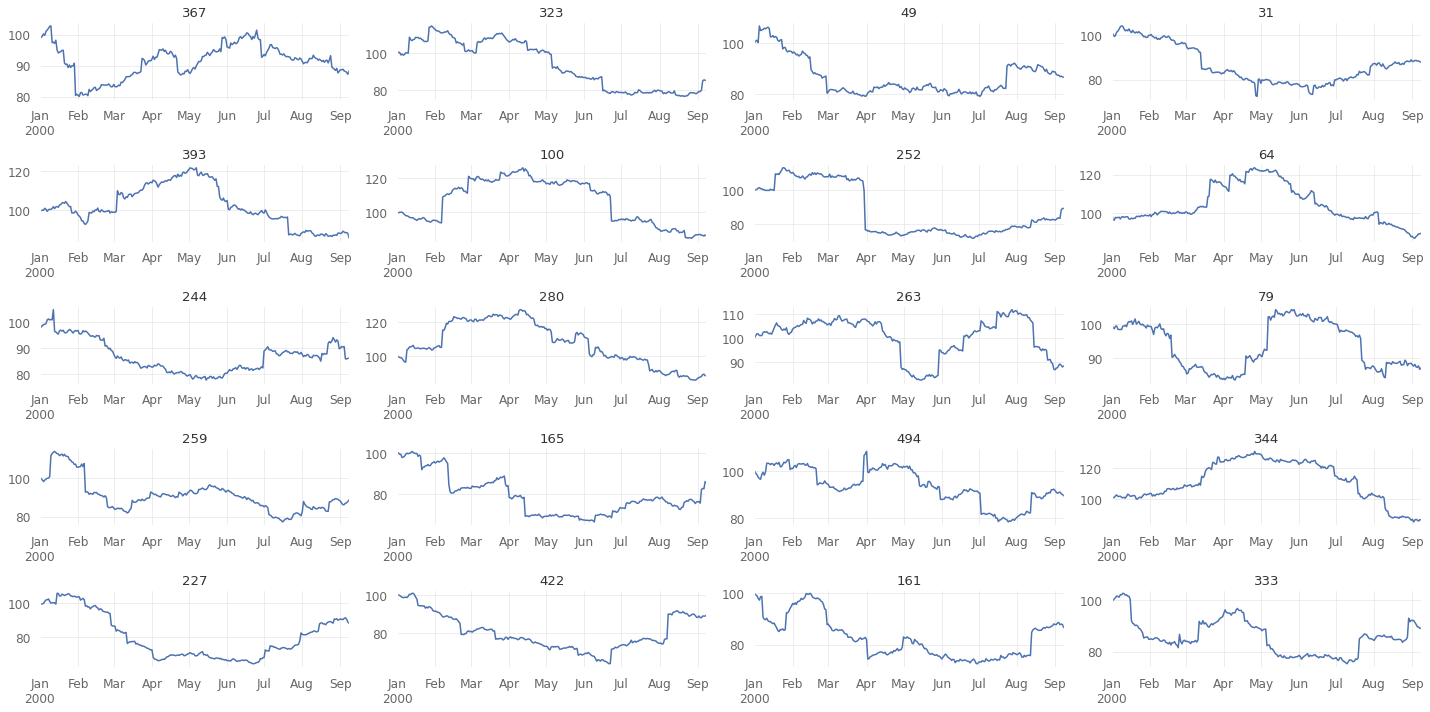

In [157]:
# Plot Each Series Groups

## Top 20
top_runs_series = [r_down.random_series[index] for index in top_runs_index]
plot_series_group(top_runs_series, series_ids=top_runs_index)

## Mid 20
mid_runs_series = [r_down.random_series[index] for index in mid_runs_index]
plot_series_group(mid_runs_series, series_ids=mid_runs_index)

## Bottom 20
bottom_runs_series = [r_down.random_series[index] for index in bottom_runs_index]
plot_series_group(bottom_runs_series, series_ids=bottom_runs_index)

## Backtest

Universes are selected based on such rules:
- Selected a diversified set of sectors from LQ45
- "Real" sectors, based on seeing the current trend
- Reduced each sector to 4 arbitrary ticker selections

We will be utilizing three variations of lookbacks 2_8, 5_20, 16_64 for each stock groups.

In [183]:
# Determine Different Universes for Strategy
stock_groups = {
    "LQ45": ['LQ45'],
    "energy_and_mining": ['BRPT.JK', 'MEDC.JK', 'ADRO.JK','ANTM.JK'],
    "retail": ['AMRT.JK', 'UNVR.JK', 'ERAA.JK', 'ASII.JK'],
    "food_agri": ['CPIN.JK', 'JPFA.JK', 'ICBP.JK', 'INDF.JK'],
    "medical": ['KLBF.JK', 'MIKA.JK']
}

# Parameters
lookback_pairs_strat = [[5, 20], [8, 32], [16, 64]]

In [203]:
config = {
            "run_params":{
                "base_data_dir": "/workspace/202205_idx-trading/_data/",
                "lq45_dir": "/workspace/202205_idx-trading/_data/20220525_lq45/",
                "lq45_index_filename": "20220525_lq45_index.csv",
                "lq45_list_filename": "20220525_lq45-list.txt"
            },

            "backtest_params":{
                "run_date_start": date_breakpoint,
                "run_date_end": "2021-01-01"
            },

            "strat_params":{
                "long_only": True,
                "tickers": None,
                "lookback_fast": None,
                "lookback_slow": None,
                "vol_lookback": 25,
                "profit_target_frac": "",
                "stop_loss_frac": ""
            }   
}

### Individual Sectors Testing

#### LQ45 Index

In [204]:
# Run Strategy
config["strat_params"]["tickers"] = stock_groups["LQ45"]

strat_df_list = []
for lp in lookback_pairs_strat:
    config["strat_params"]["lookback_fast"] = lp[0]
    config["strat_params"]["lookback_slow"] = lp[1]
    
    s = BinaryEWMACStrategy(config=config, mode="backtest")
    out_dict = s.prepare_data()
    strat_df = s.prepare_indicators(out_dict)
    strat_df = s.gen_signals(strat_df)
    
    strat_df_list.append(strat_df)

strat_df = pd.concat(strat_df_list, axis=1)

In [205]:
# Single Walk Forward Backtest
b = Backtest()
b.run(strat_df)

{'turnover': 179,
 'ratio_of_long': 1.0,
 'avg_holding_period': 41.98324022346369,
 'cum_return': 0.05173323167225563,
 'cagr': 0.004598233958320819,
 'volatility': 0.130676579688168,
 'skew': -0.28581914916366347,
 'sharpe': 0.10171094192117361,
 'prob_sharpe': 0.6298199426344523,
 'hit_ratio': 0.3128491620111732,
 'avg_ret_from_hm': (0.05757063997875045, -0.021447481176863153),
 'max_dd': -0.3154547567781877,
 'longest_dd': 2470,
 'currently_dd': True}

#### Energy and Mining

In [ ]:
# Run Strategy
config["strat_params"]["tickers"] = stock_groups["food_agri"]

strat_df_list = []
for lp in lookback_pairs_strat:
    config["strat_params"]["lookback_fast"] = lp[0]
    config["strat_params"]["lookback_slow"] = lp[1]
    
    s = BinaryEWMACStrategy(config=config, mode="backtest")
    out_dict = s.prepare_data()
    strat_df = s.prepare_indicators(out_dict)
    strat_df = s.gen_signals(strat_df)
    
    strat_df_list.append(strat_df)

strat_df = pd.concat(strat_df_list, axis=1)

In [ ]:
# Single Walk Forward Backtest
b = Backtest()
b.run(strat_df)

#### Retail

#### Food Agri

#### Medical

### Aggregate Strategy

In [ ]:
# TODO - WF Backtest, Historical Backtest, Randomized Backtest